# Logistic Regression

Using `l1` and `l2` normalization the Logistic Regression model will be used along with SMOTEEnn as a technique for the imbalance we have seen in the target variable.

Comparing this model with the LinearSVC model in the prior noteboook we will see how this model and sampling technique performs. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import recall_score, precision_recall_curve, precision_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
dummy_df = pd.read_parquet('../../../Data/dummy-term-deposit-marketing.parquet')
dummy_df.head()

,age,default,balance,housing,loan,day,campaign,y,duration_minutes,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,0,4.350000,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,0,2.516667,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,0,1.266667,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,0,2.316667,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,0,3.616667,False,...,False,False,False,False,False,False,False,True,False,False


In [3]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38335 entries, 0 to 38334
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38335 non-null  int8   
 1   default              38335 non-null  int8   
 2   balance              38335 non-null  int32  
 3   housing              38335 non-null  int8   
 4   loan                 38335 non-null  int8   
 5   day                  38335 non-null  int8   
 6   campaign             38335 non-null  int8   
 7   y                    38335 non-null  int8   
 8   duration_minutes     38335 non-null  float64
 9   job_admin            38335 non-null  bool   
 10  job_blue-collar      38335 non-null  bool   
 11  job_entrepreneur     38335 non-null  bool   
 12  job_housemaid        38335 non-null  bool   
 13  job_management       38335 non-null  bool   
 14  job_retired          38335 non-null  bool   
 15  job_self-employed    38335 non-null 

In [4]:
for col in dummy_df.columns:
    if dummy_df[col].dtype=='bool':
        dummy_df[col] = dummy_df[col].astype('category')

In [5]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38335 entries, 0 to 38334
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  38335 non-null  int8    
 1   default              38335 non-null  int8    
 2   balance              38335 non-null  int32   
 3   housing              38335 non-null  int8    
 4   loan                 38335 non-null  int8    
 5   day                  38335 non-null  int8    
 6   campaign             38335 non-null  int8    
 7   y                    38335 non-null  int8    
 8   duration_minutes     38335 non-null  float64 
 9   job_admin            38335 non-null  category
 10  job_blue-collar      38335 non-null  category
 11  job_entrepreneur     38335 non-null  category
 12  job_housemaid        38335 non-null  category
 13  job_management       38335 non-null  category
 14  job_retired          38335 non-null  category
 15  job_self-employed  

In [6]:
non_demographic_features = [
    'day',
    'campaign',
    'duration_minutes',
    'contact_unknown',
    'contact_telephone',
    'contact_cellular',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_may',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_oct',
    'month_nov',
    'month_dec'
]

In [7]:
X_dummy = dummy_df.iloc[:, ~dummy_df.columns.isin(non_demographic_features)]

In [8]:
y = X_dummy['y'].values
X = X_dummy.drop('y', axis=1)

X.head()

,age,default,balance,housing,loan,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,44,0,29,1,0,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
2,33,0,2,1,1,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,False
3,35,0,231,1,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
4,28,0,447,1,1,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,True


In [ ]:
seed = 4701

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, random_state=seed, shuffle=True
)

##### for smoteenn #####

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

smoteenn = SMOTEENN(random_state=seed)

X_train_smote, y_train_smote = smoteenn.fit_resample(X_train_scaled, y_train)
# X_train_smote, y_train_smote = smoteenn.fit_resample(X_train, y_train)

X_train_smote

array([[0.26315789, 0.        , 0.0701727 , ..., 0.        , 1.        ,
        0.        ],
       [0.13157895, 0.        , 0.0640428 , ..., 1.        , 0.        ,
        0.        ],
       [0.18421053, 0.        , 0.06334539, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.20872085, 0.        , 0.06394265, ..., 0.        , 0.        ,
        1.        ],
       [0.10415033, 0.        , 0.09820186, ..., 0.        , 0.        ,
        1.        ],
       [0.26887334, 0.        , 0.07809356, ..., 1.        , 0.        ,
        0.        ]])

In [25]:
y_train_smote = pd.Series(y_train_smote)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)
X_train_smote.head()

,age,default,balance,housing,loan,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,0.263158,0.0,0.070173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.131579,0.0,0.064043,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.184211,0.0,0.063345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.328947,0.0,0.063520,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.250000,0.0,0.063318,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [26]:
y_train_smote

0        0
1        0
2        0
3        0
4        0
        ..
34444    1
34445    1
34446    1
34447    1
34448    1
Length: 34449, dtype: int8

In [12]:
def return_scores(estimator, X_train, X_test, y_train, y_test):
    estimator = estimator
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)

    train_recall = recall_score(y_train, estimator.predict(X_train))
    test_recall = recall_score(y_test, estimator.predict(X_test))

    train_prec = precision_score(y_train, train_pred)
    test_prec = precision_score(y_test, test_pred)

    df = pd.DataFrame({
        # 'Accuracy': [train_score, test_score],
        'Recall': [train_recall, test_recall],
        'Precision': [train_prec, test_prec]
    }, index=['Train', 'Test'])

    return df

### l2 Normalization (default)

In [13]:
lr = LogisticRegression(penalty='l2', random_state=seed, solver='liblinear')

lr.fit(X_train, y_train)

LogisticRegression(random_state=4701, solver='liblinear')

In [14]:
lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

return_scores(lr, X_train, X_test, y_train, y_test)

/Users/smittyboop/Desktop/Apziva Projects/Term Deposit Marketing Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Recall,Precision
Train,0.0,0.0
Test,0.0,0.0


In [17]:
print(classification_report_imbalanced(y_test, lr_preds, zero_division=0))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      1.00      0.00      0.96      0.00      0.00      7122
          1       0.00      0.00      1.00      0.00      0.00      0.00       545

avg / total       0.86      0.93      0.07      0.89      0.00      0.00      7667



From the basic logisitic regression model we see that the model is not capturing any of the customers who subscribed.

Using the SMOTEEnn imbalanced technique we saw from Pycaret we will see if we can achieve the ~80% recall metric.

### with SMOTEEnn technique

In [19]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [27]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=seed)

In [28]:
lr.fit(X_train_smote, y_train_smote)

lr_preds_smote = lr.predict(X_test_scaled)
lr_probs_smote = lr.predict_proba(X_test_scaled)[:, 1]

return_scores(lr, X_train_smote, X_test_scaled, y_train_smote, y_test)

,Recall,Precision
Train,0.619982,0.638112
Test,0.528440,0.093174


In [29]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=lr,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LogisticRegression(random_state=4701,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

In [31]:
C_list = grid.cv_results_['param_C'].tolist()
C_list = [round(i, 4) for i in C_list]

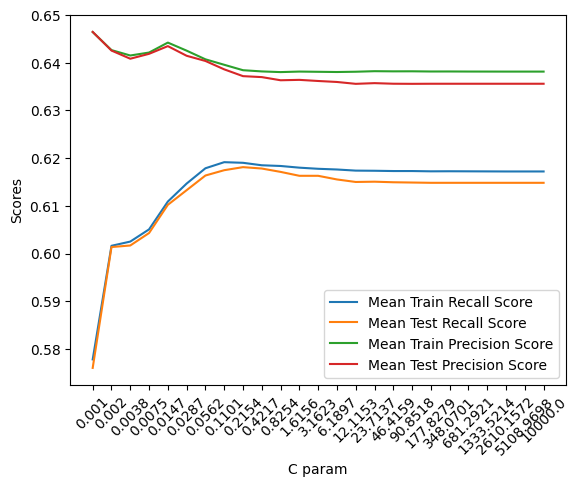

In [32]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs_smote)

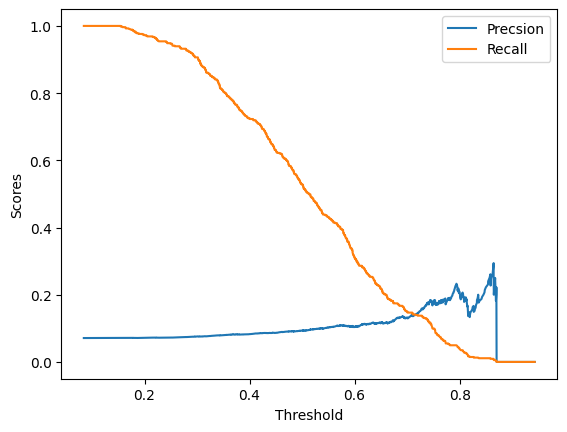

In [56]:
plt.plot(thresholds, precision[:-1], label='Precsion')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.legend()
plt.show()

In [35]:
lr_l2_tuned = LogisticRegression(penalty='l2', C=.0147, random_state=seed, solver='liblinear')

lr_l2_tuned.fit(X_train_smote, y_train_smote)

LogisticRegression(C=0.0147, random_state=4701, solver='liblinear')

In [36]:
lr_l2_preds = lr_l2_tuned.predict(X_test_scaled)

return_scores(lr_l2_tuned, X_train_smote, X_test_scaled, y_train_smote, y_test)

,Recall,Precision
Train,0.612673,0.644469
Test,0.513761,0.092869


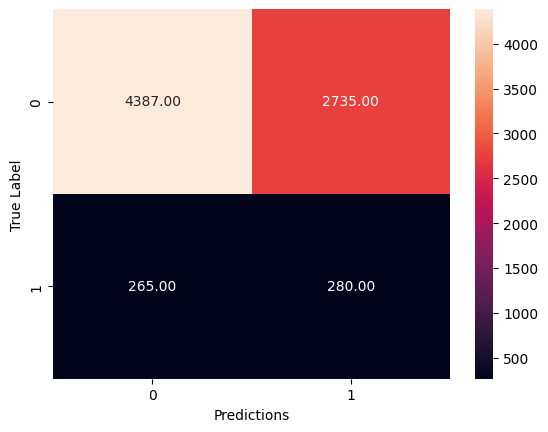

In [37]:
from sklearn.metrics import confusion_matrix

l2_tuned_smmote_conf_matrix = confusion_matrix(y_test, lr_l2_preds)

sns.heatmap(l2_tuned_smmote_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [38]:
duration_mean = dummy_df['duration_minutes'].mean()

l2_smote_true_negs = l2_tuned_smmote_conf_matrix[0][0]*duration_mean/60 ## hours
l2_smote_false_pos = l2_tuned_smmote_conf_matrix[0][1]*duration_mean/60

l2_time_saved_smote = round(l2_smote_true_negs - l2_smote_false_pos, 2)

print(f"Total time saved with sampling techniques: {l2_time_saved_smote} hours")

Total time saved with sampling techniques: 117.07 hours


In [39]:
print(classification_report_imbalanced(y_test, lr_l2_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.62      0.51      0.75      0.56      0.32      7122
          1       0.09      0.51      0.62      0.16      0.56      0.31       545

avg / total       0.88      0.61      0.52      0.70      0.56      0.32      7667



## l1 normalization with SMOTEEnn

In [40]:
lr_l1 = LogisticRegression(penalty='l1', random_state=seed, solver='liblinear')

lr_l1.fit(X_train_smote, y_train_smote)

LogisticRegression(penalty='l1', random_state=4701, solver='liblinear')

In [41]:
lr_preds = lr_l1.predict(X_test_scaled)
lr_l1_probs = lr_l1.predict_proba(X_test_scaled)

return_scores(lr_l1, X_train_smote, X_test_scaled, y_train_smote, y_test)

,Recall,Precision
Train,0.620336,0.639135
Test,0.528440,0.093416


In [42]:
params = {
    'C': 10**np.linspace(-3,4,25)
}

grid = GridSearchCV(
    estimator=lr_l1,
    param_grid=params,
    scoring=['recall', 'precision'],
    n_jobs=-1,
    cv=kfold,
    return_train_score=True,
    refit=False
)

grid.fit(X_train_smote, y_train_smote)

/Users/smittyboop/Desktop/Apziva Projects/Term Deposit Marketing Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smittyboop/Desktop/Apziva Projects/Term Deposit Marketing Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smittyboop/Desktop/Apziva Projects/Term Deposit Marketing Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

GridSearchCV(cv=KFold(n_splits=5, random_state=4701, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=4701,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.95734178e-03, 3.83118685e-03, 7.49894209e-03,
       1.46779927e-02, 2.87298483e-02, 5.62341325e-02, 1.10069417e-01,
       2.15443469e-01, 4.21696503e-01, 8.25404185e-01, 1.61559810e+00,
       3.16227766e+00, 6.18965819e+00, 1.21152766e+01, 2.37137371e+01,
       4.64158883e+01, 9.08517576e+01, 1.77827941e+02, 3.48070059e+02,
       6.81292069e+02, 1.33352143e+03, 2.61015722e+03, 5.10896977e+03,
       1.00000000e+04])},
             refit=False, return_train_score=True,
             scoring=['recall', 'precision'])

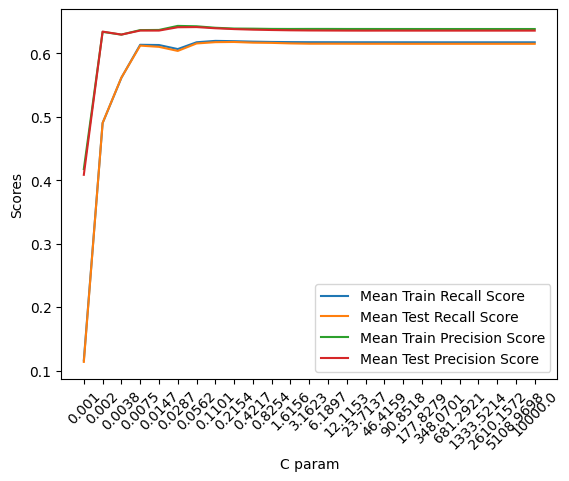

In [43]:
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_recall'], label='Mean Train Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_recall'], label='Mean Test Recall Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_train_precision'], label='Mean Train Precision Score')
plt.plot(np.arange(len(C_list)), grid.cv_results_['mean_test_precision'], label='Mean Test Precision Score')
plt.ylabel('Scores')
plt.xlabel('C param')
plt.xticks(np.arange(len(C_list)), labels=C_list, rotation=45)
plt.legend()
plt.show()

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_l1_probs[:, 1])

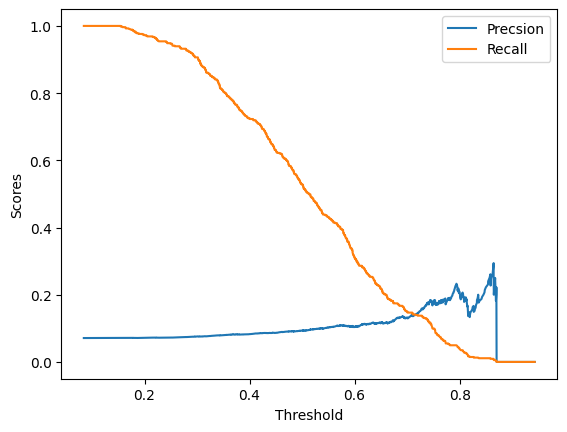

In [45]:
plt.plot(thresholds, precision[:-1], label='Precsion')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.legend()
plt.show()

### l1 with SMOTEEnn

In [46]:
lr_l1_tuned = LogisticRegression(penalty='l1',
                                 solver='liblinear',
                                 C=.0075,
                                 random_state=seed)

In [48]:
lr_l1_tuned.fit(X_scaled_smote, y_scaled_smote)

l1_preds_tuned_smote = lr_l1.predict(X_test_scaled)
l1_probs_tuned_smote = lr_l1.predict_proba(X_test_scaled)

return_scores(lr_l1_tuned, X_train_smote, X_test_scaled, y_train_smote, y_test)

,Recall,Precision
Train,0.628470,0.63521
Test,0.541284,0.09268


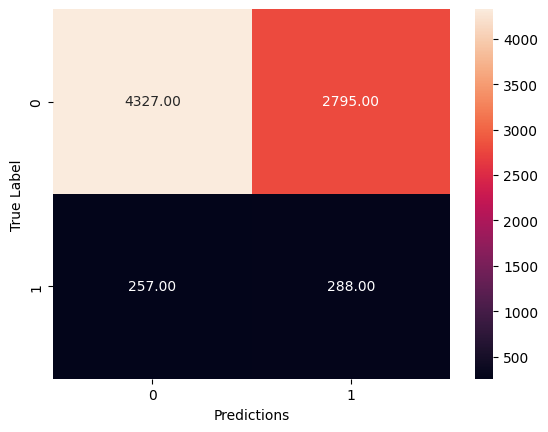

In [49]:
l1_tuned_smote_conf_matrix = confusion_matrix(y_test, l1_preds_tuned_smote)

sns.heatmap(l1_tuned_smote_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [51]:
l1_smote_true_negs = l1_tuned_smote_conf_matrix[0][0]*duration_mean/60 ## hours
l1_smote_false_pos = l1_tuned_smote_conf_matrix[0][1]*duration_mean/60

l1_time_saved_smote = round(l1_smote_true_negs - l1_smote_false_pos, 2)

print(f"Total time saved with LogReg l1 model using SMOTEEnn: {l1_time_saved_smote} hours")
print(f"Total time saved with LogReg l2 model using SMOTEEnn: {l2_time_saved_smote} hours")

Total time saved with LogReg l1 model using SMOTEEnn: 108.57 hours
Total time saved with LogReg l2 model using SMOTEEnn: 117.07 hours


In [55]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, l1_preds_tuned_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.61      0.53      0.74      0.57      0.32      7122
          1       0.09      0.53      0.61      0.16      0.57      0.32       545

avg / total       0.88      0.60      0.53      0.70      0.57      0.32      7667



Initially, from the model selection phase, a logistic regression model or a ridge classifier performed well with SMOTEEnn to obtain a decent recall score. But after going through this notebook we saw that the recall score was misleading. While the recall score was high in the preliminary modeling, the recall score in this notebook never surpassed ~65%. 

The precision score was nowhere near good enough to contend with the time saved from the LinearSVC model.

## Whole Dataset Prediction

In [59]:
X = dummy_df.drop('y', axis=1)
X.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,1,4.350000,False,False,...,False,False,False,False,False,False,False,True,False,False
1,44,0,29,1,0,5,1,2.516667,False,False,...,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,1,1.266667,False,False,...,False,False,False,False,False,False,False,True,False,False
3,35,0,231,1,0,5,1,2.316667,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,0,447,1,1,5,1,3.616667,False,False,...,False,False,False,False,False,False,False,True,False,False


In [60]:
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(
    X, y, random_state=seed, shuffle=True, train_size=.80
)

X_train_whole_scaled = scaler.fit_transform(X_train_whole, y_train_whole)
X_test_whole_scaled = scaler.transform(X_test_whole)

X_train_whole_smote, y_train_whole_smote = smoteenn.fit_resample(X_train_whole_scaled, y_train_whole)

In [62]:
y_train_whole_smote = pd.Series(y_train_whole_smote)

X_test_whole_scaled = pd.DataFrame(X_test_whole_scaled, columns=X_test_whole.columns)
X_train_whole_smote = pd.DataFrame(X_train_whole_smote, columns=X_train_whole.columns)
X_train_whole_smote.head()

,age,default,balance,housing,loan,day,campaign,duration_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0.197368,0.0,0.066236,0.0,0.0,0.900000,0.000000,0.010372,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.263158,0.0,0.070173,1.0,0.0,0.233333,0.017544,0.048810,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.131579,0.0,0.063979,1.0,0.0,0.400000,0.000000,0.009965,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.131579,0.0,0.064043,0.0,0.0,0.133333,0.070175,0.113484,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.184211,0.0,0.063345,1.0,0.0,0.400000,0.140351,0.001627,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [63]:
final_lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=seed, C=.0147)

final_lr.fit(X_train_whole_smote, y_train_whole_smote)

LogisticRegression(C=0.0147, random_state=4701, solver='liblinear')

In [65]:
lr_preds = final_lr.predict(X_test_whole_scaled)

return_scores(final_lr, X_train_whole_smote, X_test_whole_scaled, y_train_whole_smote, y_test_whole)

,Recall,Precision
Train,0.872914,0.860573
Test,0.809174,0.229329


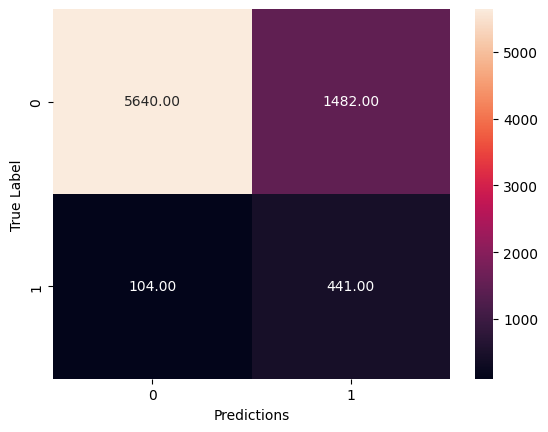

In [67]:
whole_conf_matrix = confusion_matrix(y_test_whole, lr_preds)

sns.heatmap(whole_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predictions')
plt.ylabel('True Label')
plt.show()

In [68]:
whole_true_negs = whole_conf_matrix[0][0]*duration_mean/60 ## hours
whole_false_pos = whole_conf_matrix[0][1]*duration_mean/60

whole_time_saved_smote = round(whole_true_negs - whole_false_pos, 2)

print(f"Total time saved with LogReg l1 model using SMOTEEnn: {l1_time_saved_smote} hours")
print(f"Total time saved with LogReg l2 model using SMOTEEnn: {l2_time_saved_smote} hours")
print(f"Whole dataset time saved with LogReg l2 model using SMOTEEnn: {whole_time_saved_smote} hours")

Total time saved with LogReg l1 model using SMOTEEnn: 108.57 hours
Total time saved with LogReg l2 model using SMOTEEnn: 117.07 hours
Whole dataset time saved with LogReg l2 model using SMOTEEnn: 294.67 hours


In [74]:
print(classification_report_imbalanced(y_test_whole, lr_preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.79      0.81      0.88      0.80      0.64      7122
          1       0.23      0.81      0.79      0.36      0.80      0.64       545

avg / total       0.93      0.79      0.81      0.84      0.80      0.64      7667



As noted before, before we looked at the dataset as a whole, the logistic regression model does not seem to be performing better than the LinearSVC model from the prior notebook.

But after looking at the whole dataset the model predictions improved as well as call time saved, but not so much as to mave along with this model.

We will look at ensemble methods in the ensemble.ipynb next...

In [75]:
coef_df = pd.DataFrame({
    'Coefficients': final_lr.coef_[0]
}, index=X.columns).sort_values(by='Coefficients', ascending=True)

coef_df.head(10)

,Coefficients
month_jan,-1.545536
month_aug,-1.165569
contact_unknown,-0.851404
month_jul,-0.772033
month_nov,-0.750344
loan,-0.561318
housing,-0.556362
campaign,-0.535797
job_housemaid,-0.462051
age,-0.374486


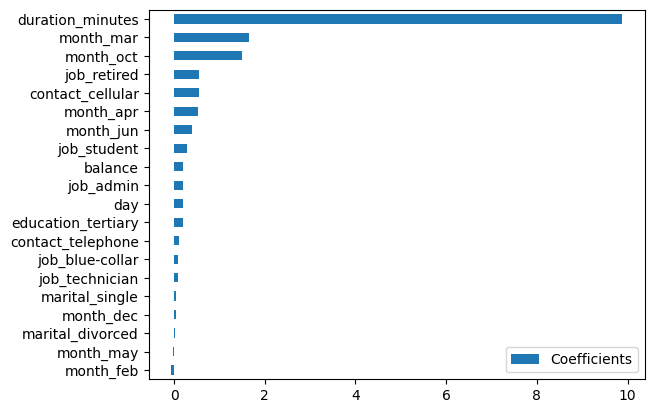

In [76]:
coef_df.tail(20).plot(kind='barh')
plt.show()